In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
import operator #for sorting 
from sklearn import preprocessing # for normalization 
from collections import Counter #finding the majority 

#Text Preprocessing 
import re # for number removal 
import string # for punctutation removal 

import nltk 
## for stopword removal
from nltk.corpus import stopwords
nltk.download('stopwords')
stopWords= stopwords.words('english')
## lemmatization 
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')
lemmatizer= WordNetLemmatizer()
from nltk.tokenize import word_tokenize

import pickle  #save variables to file

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/celine/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /Users/celine/nltk_data...
[nltk_data] Downloading package punkt to /Users/celine/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sub_sample=pd.read_csv('sample_submission.csv')
test_lab= pd.read_csv('test_labels.csv')
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
test_df.head(2)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...


In [4]:
#Checking incomplete cases 
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


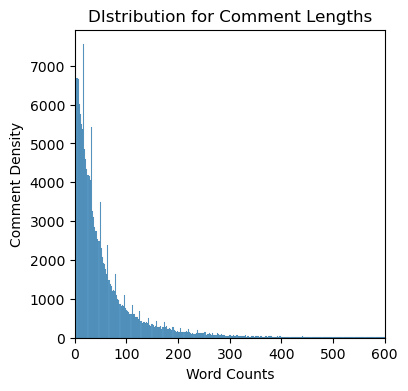

In [5]:
#Checking comment lengths
comm_len = train_df["comment_text"].str.split().apply(len)
plt.figure(figsize=(4,4))
sns.histplot(comm_len)
plt.title("DIstribution for Comment Lengths")
plt.xlim(0,600)
plt.xlabel("Word Counts")
plt.ylabel("Comment Density")
plt.show()

In [6]:
# Toxic vs. clean comment 
clean_comm= (train_df.iloc[:,2:].sum(axis=1)==0).sum(axis=0)
clean_comm
print("The clean comment ratio is:",(round(clean_comm/len(train_df),3)))

The clean comment ratio is: 0.898


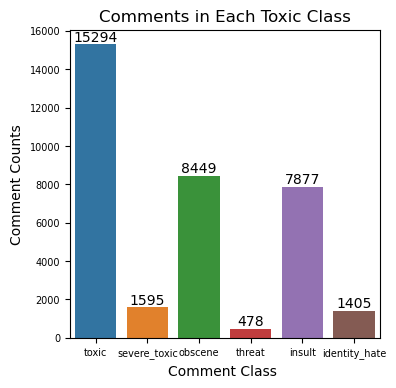

In [7]:
#Ratio of comments in each toxic class

categories= list(train_df.columns.values[2:])
                 
counts=[]
for category in categories:
    count=train_df[category].sum()
    ratio= round(count/len(train_df),3)
    counts.append((category,count,ratio))
category_stat = pd.DataFrame(counts, columns=["Class","Counts","Percentage"])
category_stat
plt.figure(figsize=(4,4))
ax= sns.barplot(x="Class",y="Counts",data=category_stat)
ax.bar_label(ax.containers[0])
plt.title("Comments in Each Toxic Class")
plt.ylabel('Comment Counts')
plt.xlabel('Comment Class ')
plt.rcParams.update({'font.size':4})
ax.tick_params(labelsize=7)

Text(0.5, 0, 'Classes Counts')

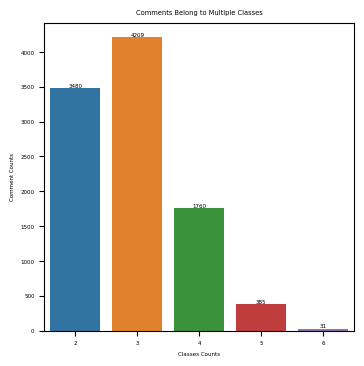

In [8]:
#Comments belong to multiple classes by getting rowSums 
multiClass_comm= train_df.iloc[:,2:].sum(axis=1).value_counts()
multiClass= multiClass_comm[multiClass_comm.index>1]
plt.figure(figsize=(4,4))
ax=sns.barplot(x=multiClass.index, y=multiClass.values)
ax.bar_label(ax.containers[0])
plt.title("Comments Belong to Multiple Classes")
plt.ylabel('Comment Counts')
plt.xlabel('Classes Counts')

The target columns are: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


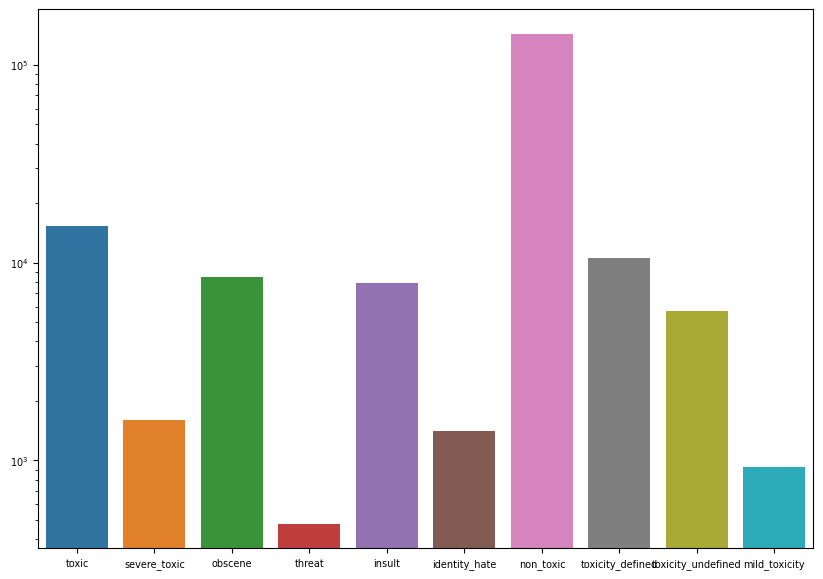

In [9]:
target_col = list(train_df.columns.drop(['id','comment_text']))
print("The target columns are:",target_col)
#fill toxic column of sever toxic comments with 1 
train_df.loc[train_df['severe_toxic']==1,'toxic'] =1

# non-toxic comments are identified when all target_col value is 0. New column has been created,
# if value of 1 then the comment is nontoxic
train_df['non_toxic'] = 1-train_df[target_col].max(axis=1)

# Since labels nested under each other in some cases, comments with toxicity defined are identified
# with new column
train_df['toxicity_defined'] = train_df[['insult', 'obscene', 'identity_hate', 'threat']].max(axis=1)

# New toxic_undefined column for toxic comments but with no characteristic
train_df['toxicity_undefined'] = 0  # initiziling all value of 0
# for each comment that's not toxicity defined but labelled as toxic, labeled them as 1 in new column
train_df.loc[(train_df['toxicity_defined'] == 0) & (train_df['toxic'] == 1), 'toxicity_undefined'] = 1

# New mild_toxicity column for comment with toxicity defined but not labeled as toxic/severe toxic
train_df['mild_toxicity'] = 0
train_df.loc[(train_df['toxicity_defined'] == 1) & (train_df['toxic'] == 0) & (train_df['severe_toxic'] == 0),
             'mild_toxicity'] = 1
target_column =list(train_df.columns.drop(['id','comment_text'])) 
labelC = train_df[target_column].sum()
plt.figure(figsize=(10,7))
ax = sns.barplot(x=labelC.index, y=labelC.values,dodge=False)
ax.set_yscale('log')
ax.tick_params(labelsize=7)

In [10]:
train_df[['mild_toxicity']].value_counts()

mild_toxicity
0                158640
1                   931
dtype: int64

In [11]:
#Now, we would create one variable including 4 levels:
# level 0: Non-toxic comment (6% of the original dataset)
# level 1: Mild_toxicity
# level 2: Toxic (since all severe toxic comment are labeled as 1 in toxic comment, they are removed)
# level 3: severe_toxic 

train_df['toxicity_level']=0 #initializing a column of 0 
train_df.loc[(train_df['non_toxic']==1),'toxicity_level']=1
train_df.loc[(train_df['mild_toxicity']==1),'toxicity_level']=2
train_df.loc[(train_df['toxic']==1)& (train_df['severe_toxic']==0),'toxicity_level']=3
train_df.loc[(train_df['severe_toxic']==1), 'toxicity_level']=4

#drop rows with toxicity level undefined 
train_df= train_df[train_df['toxicity_level']!= 0]
train_df.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic,toxicity_defined,toxicity_undefined,mild_toxicity,toxicity_level
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,0,0,0,1


In [12]:
train_df=train_df[['comment_text','non_toxic','mild_toxicity','toxic','severe_toxic','toxicity_level']]
train_df.head(3)

,comment_text,non_toxic,mild_toxicity,toxic,severe_toxic,toxicity_level
0,Explanation\nWhy the edits made under my usern...,1,0,0,0,1
1,D'aww! He matches this background colour I'm s...,1,0,0,0,1
2,"Hey man, I'm really not trying to edit war. It...",1,0,0,0,1


In [13]:
print(train_df[['non_toxic']].shape)
nonToxic= train_df[train_df['toxicity_level']==1].sample(frac=0.01,random_state=961)
nonToxic.shape

(159571, 1)


(1433, 6)

In [14]:
toxic = train_df[train_df['toxicity_level']==3].sample(frac=0.1,random_state=961)
print(toxic.shape)
trainB= nonToxic.append(toxic)
trainB.shape

(1370, 6)


/var/folders/kk/8bhkmrmx1r18z0wsy85f6m_c0000gn/T/ipykernel_19007/2466482162.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trainB= nonToxic.append(toxic)


(2803, 6)

In [15]:
train_df= trainB.append(train_df[(train_df['toxicity_level']==2)|(train_df['toxicity_level']==4)])
print(train_df[['toxicity_level']].value_counts())
print(train_df[train_df['mild_toxicity']==1].shape)

toxicity_level
4                 1595
1                 1433
3                 1370
2                  931
dtype: int64
(931, 6)


/var/folders/kk/8bhkmrmx1r18z0wsy85f6m_c0000gn/T/ipykernel_19007/3086354637.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df= trainB.append(train_df[(train_df['toxicity_level']==2)|(train_df['toxicity_level']==4)])


In [16]:
#make sure the toxic comments does not include severe toxic comments 
train_df.loc[train_df['severe_toxic']==1,'toxic'] =0

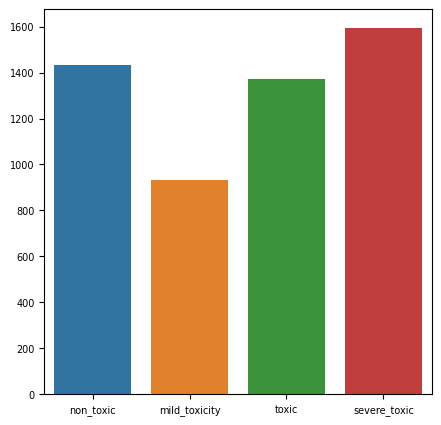

In [17]:
targetB= list(train_df.columns.drop(['comment_text','toxicity_level']))
labelB= train_df[targetB].sum()
plt.figure(figsize=(5,5))
ax = sns.barplot(x=labelB.index, y=labelB.values)
ax.tick_params(labelsize=7)

In [19]:
#Text Preprocessing 

#Removing punctuations'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
def remove_punc(comment):
    nonPunc="".join([letter for letter in comment if letter not in string.punctuation])
    return nonPunc

#Lowering the text
def toLower(comment):
    return comment.lower()

#Removing numbers 
def replace_numbers(comment):
    """Replace all interger occurrences in 
    list of tokenized words with textual representation"""
    return re.sub(r'\d+', '', comment)

#Removing whitespaces
def remove_space(comment):
    return comment.strip()

#Tokenization
def text2word(comment):
    return word_tokenize(comment)

#Removing Stop words
def remove_stopW(words,stopWords):
    return [word for word in words if word not in stopWords]

#Lemmatization
def lematizer(words):
    lemmatizer = WordNetLemmatizer()
    lemm_comm= [lemmatizer.lemmatize(word) for word in words]
    return lemm_comm

def lematizer_verb(words):
    lemmatizer = WordNetLemmatizer()
    lemm_comm= [lemmatizer.lemmatize(word,"v") for word in words]
    return lemm_comm


def clean_comment(comment):
    comment= remove_punc(comment)
    comment= toLower(comment)
    comment= replace_numbers(comment)
    comment= remove_space(comment)
    words=text2word(comment)
    words=remove_stopW(words,stopWords)
    words=lematizer(words)
    words=lematizer_verb(words)
    
    return ' '.join(words)

train_df['comment_text'] = train_df['comment_text'].apply(lambda x: clean_comment(x))
test_df['comment_text'] = test_df['comment_text'].apply(lambda x: clean_comment(x))


LookupError: 
**********************************************************************
  Resource [93momw-1.4[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('omw-1.4')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/omw-1.4[0m

  Searched in:
    - '/Users/celine/nltk_data'
    - '/Users/celine/opt/anaconda3/nltk_data'
    - '/Users/celine/opt/anaconda3/share/nltk_data'
    - '/Users/celine/opt/anaconda3/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [ ]:
train_df["comment_text"].iloc[2]

'article cant remember password jim bakken im fieldgoalunit include tyldesley complete worcs time ill summarise test cricket time study protocol detail im afraid fact apart typo link need fix would grateful someone would many cricket article inaccuracy ramble tale attach bob taylor one worst wrong match highest score wrong series night watchman story therefore nonsense also never challenge knott place'

In [ ]:
train_df= train_df.reset_index(drop=True)
train_df.head(5)

,comment_text,non_toxic,mild_toxicity,toxic,severe_toxic,toxicity_level
0,sorry break unsourced film plot much error uns...,1,0,0,0,1
1,criticism criticism doesnt belong title busine...,1,0,0,0,1
2,article cant remember password jim bakken im f...,1,0,0,0,1
3,prospective mega man music article sure im wil...,1,0,0,0,1
4,seem fine didnt realize much check ref article...,1,0,0,0,1


In [ ]:
#store variables to file
clean_data = [train_df, test_df]
with open('clean_data.p', 'wb') as my_file_object:
    pickle.dump(clean_data, my_file_object)